In [1]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [2]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, yusers_array, yusers_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
    
nExp = yExp.size


Compute the FeedForward NN : testing MLP with 2 layers and 20 weights per layer (similar to the simulink)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class FFmodel(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
           - Number of hidden layers is 2
        Nh1 - Neurons in the hidden layer 1
        No - Output size
        """
        super().__init__()
        
        self.W1 = nn.Parameter(torch.randn(Nh1, Ni))
        self.W2 = nn.Parameter(torch.randn(Nh2, Nh1))
        self.W3 = nn.Parameter(torch.randn(No, Nh2))
        #self.fc1 =  #nn.Linear(in_features=Ni, out_features=Nh)
        #self.out =  #nn.Linear(in_features=Nh, out_features=No)
        self.act = nn.Sigmoid() # activation function (sigmoid, relu, tanh)
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.W1 @ x)  #sigma(W1*x)     first hidden layer with sigmoid
        x = self.act2(self.W2 @ x) # RELU(W2*x)     second hidden layer with RELU
        x = self.W3 @ x # output layer (no activation function)
        return x

In [4]:
# Parameters
ti = dExp[0 ,0].shape[0]  # Number of time steps

#initialize
d_users = torch.zeros(nExp*ti, 3)
y_users = torch.zeros(nExp*ti)

for j in range(nExp):
    d_users[j*ti:(j+1)*ti,:] = torch.from_numpy(dExp[0, j][:, :-2]).squeeze()# only 3 first inputs
    y_users[j*ti:(j+1)*ti] = torch.from_numpy(yusers_array[j*ti:(j+1)*ti,0]) 

# Initialize the model, loss function, and optimizer
Ni = 3  # Number of inputs
Nh1 = 20
Nh2 = 20
No = 1  # Number of output

model = FFmodel(Ni, Nh1, Nh2, No)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Load the model parameters before starting a new training session
model.load_state_dict(torch.load('parameters_FFN.pth'))  #for Qu

# Prepare the data (reshape for Conv1D)
# Assuming nExp is defined and you have filled d_users and y_users accordingly
d_users = d_users.view(-1, 3, ti)  # Shape: (nExp, 3, ti)
y_users = y_users.view(-1, ti)      # Shape: (nExp, ti)

# Training loop (simple example)
num_epochs = 5000
for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(d_users.float())  # Ensure inputs are float
    loss = criterion(outputs, y_users.float())  # Compute loss

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    predictions = model(d_users.float())
    print("Predictions accuracy:", predictions-y_users.float())


C:\Users\adela\AppData\Local\Temp\ipykernel_19548\2765349311.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('parameters_FFN.pth'))  #f

Epoch [1/5000], Loss: 0.0358
Epoch [2/5000], Loss: 0.1225
Epoch [3/5000], Loss: 0.0414
Epoch [4/5000], Loss: 0.0549
Epoch [5/5000], Loss: 0.0855
Epoch [6/5000], Loss: 0.0717
Epoch [7/5000], Loss: 0.0449
Epoch [8/5000], Loss: 0.0360
Epoch [9/5000], Loss: 0.0478
Epoch [10/5000], Loss: 0.0599
Epoch [11/5000], Loss: 0.0578
Epoch [12/5000], Loss: 0.0460
Epoch [13/5000], Loss: 0.0368
Epoch [14/5000], Loss: 0.0374
Epoch [15/5000], Loss: 0.0445
Epoch [16/5000], Loss: 0.0490
Epoch [17/5000], Loss: 0.0464
Epoch [18/5000], Loss: 0.0400
Epoch [19/5000], Loss: 0.0360
Epoch [20/5000], Loss: 0.0372
Epoch [21/5000], Loss: 0.0411
Epoch [22/5000], Loss: 0.0431
Epoch [23/5000], Loss: 0.0412
Epoch [24/5000], Loss: 0.0376
Epoch [25/5000], Loss: 0.0358
Epoch [26/5000], Loss: 0.0369
Epoch [27/5000], Loss: 0.0391
Epoch [28/5000], Loss: 0.0398
Epoch [29/5000], Loss: 0.0383
Epoch [30/5000], Loss: 0.0363
Epoch [31/5000], Loss: 0.0358
Epoch [32/5000], Loss: 0.0369
Epoch [33/5000], Loss: 0.0380
Epoch [34/5000], Lo

In [5]:
#initialize
d_users_val = torch.zeros(ti, 3)
y_users_val = torch.zeros(ti)

d_users_val[:,:] = torch.from_numpy(dExp_val[0, 0][:, :-2]).squeeze()# only 3 first inputs
y_users_val[:] = torch.from_numpy(yusers_val[:,0]) 

# Get CNN output for validation data
# Prepare the data (reshape for Conv1D)
# Assuming nExp is defined and you have filled d_users and y_users accordingly
d_users_val = d_users_val.view(-1, 3, ti)  # Shape: (nExp, 3, ti)
y_users_val = y_users_val.view(-1, ti)      # Shape: (nExp, ti)
y_val = model(d_users_val).squeeze(0)

# Calculate loss for validation data
loss_val = criterion(y_val, y_users_val)

In [6]:
# Save the model parameters after training
torch.save(model.state_dict(), 'parameters_FFN.pth') # saved for Qu
print(predictions.squeeze().shape)
print(y_val.shape)
print(y_users_val.shape)

torch.Size([2, 30240])
torch.Size([1, 30240])
torch.Size([1, 30240])


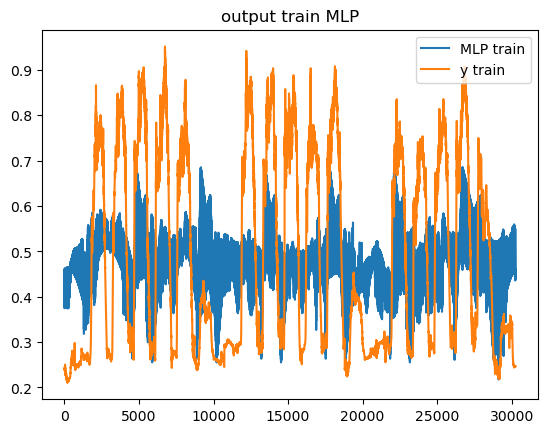

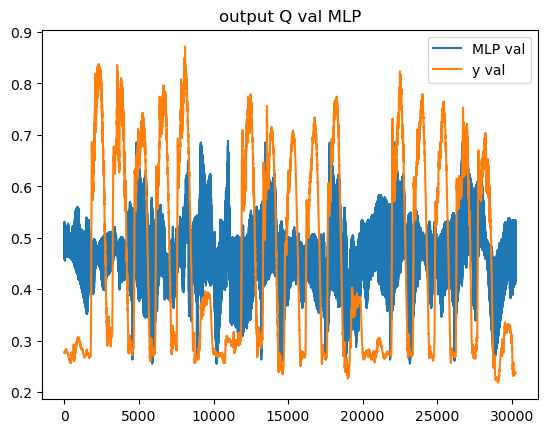

In [7]:
# Plot output Q for training data
plt.figure('1')
plt.plot(predictions[0, :].squeeze().detach().numpy(), label='MLP train')
plt.plot(y_users[0,:].detach().numpy(), label='y train')
plt.title("output train MLP")
plt.legend()
plt.show()

# Plot output Q for validation data
plt.figure('2')
plt.plot(y_val[0, :].detach().numpy(), label='MLP val')
plt.plot(y_users_val[0, :].detach().numpy(), label='y val')
plt.title("output Q val MLP")
plt.legend()
plt.show()

In [34]:
print("Predictions accuracy:", predictions) # nExp, ti

Predictions accuracy: tensor([[[0.4320, 0.4262, 0.3814,  ..., 0.4387, 0.4806, 0.3813]],

        [[0.4441, 0.3974, 0.3814,  ..., 0.4267, 0.4420, 0.3813]]])


In [35]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 3
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    #if input_size ==4:
     #   u[j, :, :] = (torch.from_numpy(dExp[0, j][:, :-1])) #suppress last column
    #else :
    u[j, :, :] = torch.cat(
        (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
        predictions[j, 0, :].unsqueeze(1)),     # Add extra dimension to predictions using unsqueeze(1)
        dim=-1
        )       
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 13))
    #plt.plot(u[j, :, 4])

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [37]:
#Set dimensions for RNN layers
idd = input_size
hdd = 10
ldd = 2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
RNN = RNNModel(idd, hdd, ldd, odd)

# Load the model parameters before starting a new training session
RNN.load_state_dict(torch.load('parameters_RNN_with_FFN.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 50

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [38]:
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(RNN.state_dict(), f'parameters_RNN_with_FFN.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")

Epoch: 1 	||	 Loss: 0.7528444528579712
Epoch: 2 	||	 Loss: 0.5667288899421692
Epoch: 3 	||	 Loss: 0.4062163233757019
Epoch: 4 	||	 Loss: 0.27333882451057434
Epoch: 5 	||	 Loss: 0.17480280995368958
Epoch: 6 	||	 Loss: 0.10504768043756485
Epoch: 7 	||	 Loss: 0.05256015062332153
Epoch: 8 	||	 Loss: 0.019027378410100937
Epoch: 9 	||	 Loss: 0.005363812204450369
Epoch: 10 	||	 Loss: 0.006902757566422224
Epoch: 11 	||	 Loss: 0.01668791100382805
Epoch: 12 	||	 Loss: 0.027665385976433754
Epoch: 13 	||	 Loss: 0.034755267202854156
Epoch: 14 	||	 Loss: 0.03600086271762848
Epoch: 15 	||	 Loss: 0.03198971599340439
Model parameters saved at epoch 15
Epoch: 16 	||	 Loss: 0.02466171234846115
Epoch: 17 	||	 Loss: 0.016351968050003052
Epoch: 18 	||	 Loss: 0.00918627344071865
Epoch: 19 	||	 Loss: 0.004688006825745106
Epoch: 20 	||	 Loss: 0.0034784136805683374
Epoch: 21 	||	 Loss: 0.005126753821969032
Epoch: 22 	||	 Loss: 0.008353156968951225
Epoch: 23 	||	 Loss: 0.01161223091185093
Epoch: 24 	||	 Loss: 0.

In [25]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

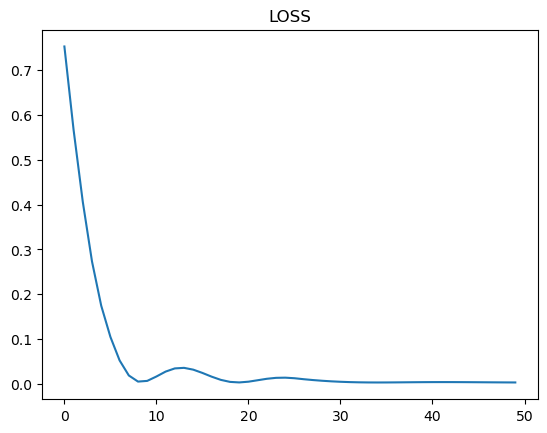

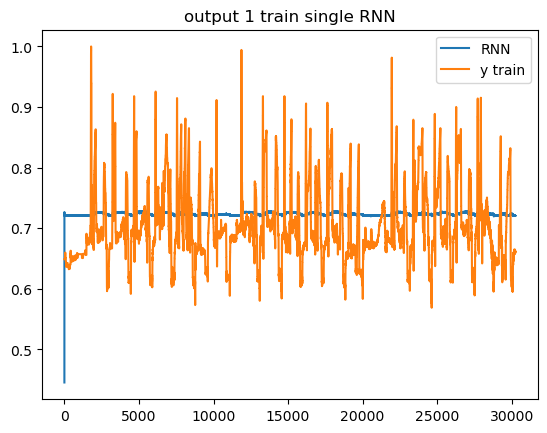

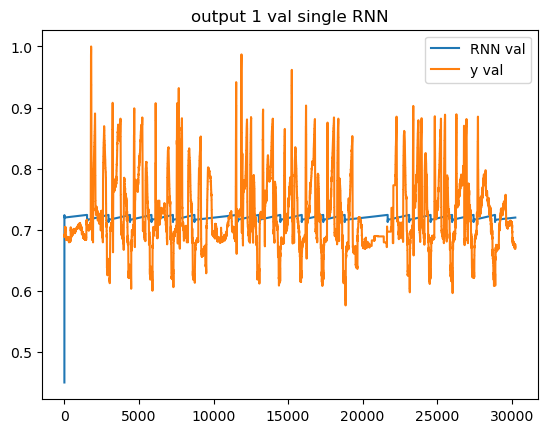

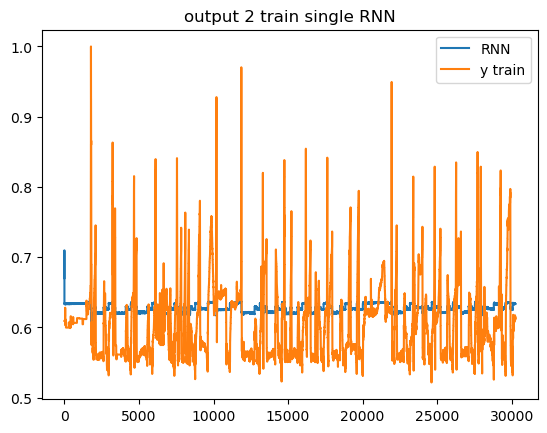

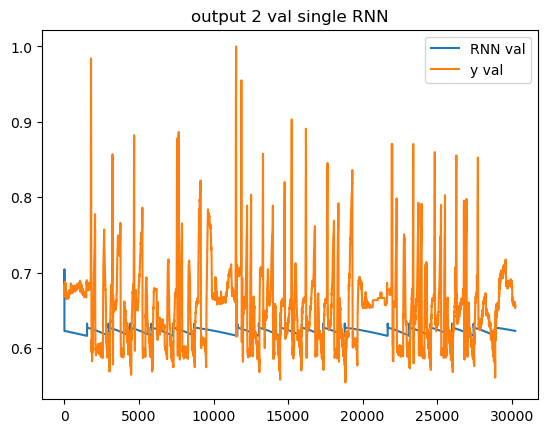

Loss Validation single RNN: 0.003755910089239478


In [26]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yRNN[0, :, 0].detach().numpy(), label='RNN')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, :, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yRNN[0, :, 1].detach().numpy(), label='RNN')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")

In [ ]:
0.0052    / 0.0037  / 0.003